<a href="https://colab.research.google.com/github/agungjwndn/Agung-Jiwandanu_Final_Project/blob/main/spoofing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simdkalman

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving submission.csv to submission.csv


In [152]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import sparse
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import simdkalman
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
from warnings import simplefilter

simplefilter('ignore')
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option('max_rows', 100)

In [151]:
model_name = 'nn_v2'

data_dir = Path('../submission.csv')
train_file = data_dir / 'submission.csv'
test_file = data_dir / 'submission.csv'
sample_file = data_dir / 'submission.csv'

build_dir = Path('./build')
build_dir.mkdir(parents=True, exist_ok=True)
predict_val_file = build_dir / f'{model_name}.val.txt'
predict_tst_file = build_dir / f'{model_name}.tst.txt'
submission_file = 'submission.csv'

cname_col = 'collectionName'
pname_col = 'phoneName'
phone_col = 'phone'
ts_col = 'millisSinceGpsEpoch'
dt_col = 'datetime'
lat_col = 'latDeg'
lon_col = 'lngDeg'

lrate = .01
batch_size = 2048
epochs = 150
n_stop = 10
n_fold = 25
seed = 42

In [154]:
def gnss_log_to_dataframes(path):
    print('Loading ' + path, flush=True)
    gnss_section_names = {'Raw','UncalAccel', 'UncalGyro', 'UncalMag', 'Fix', 'Status', 'OrientationDeg'}
    with open(path) as f_open:
        datalines = f_open.readlines()

    datas = {k: [] for k in gnss_section_names}
    gnss_map = {k: [] for k in gnss_section_names}
    for dataline in datalines:
        is_header = dataline.startswith('#')
        dataline = dataline.strip('#').strip().split(',')
        if is_header and dataline[0] in gnss_section_names:
            gnss_map[dataline[0]] = dataline[1:]
        elif not is_header:
            datas[dataline[0]].append(dataline[1:])

    results = dict()
    for k, v in datas.items():
        results[k] = pd.DataFrame(v, columns=gnss_map[k])
    for k, df in results.items():
        for col in df.columns:
            if col == 'CodeType':
                continue
            results[k][col] = pd.to_numeric(results[k][col])

    return results

In [157]:
import folium
from folium import plugins


def simple_folium(df:pd.DataFrame, lat_col:str, lon_col:str):

    df = df[df[lat_col].notnull() & df[lon_col].notnull()]
    df_locs = list(df[[lat_col, lon_col]].values)
    fol_map = folium.Map([df[lat_col].median(), df[lon_col].median()])
    heat_map = plugins.HeatMap(df_locs)
    fol_map.add_child(heat_map)
    markers = plugins.MarkerCluster(locations = df_locs)
    fol_map.add_child(markers)
    folium.LayerControl().add_to(fol_map)
    return fol_map

In [158]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(a**0.5)
    dist = 6_367_000 * c
    return dist

In [159]:
T = 0.80
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[phone_col].unique()
    for phone in tqdm(unique_paths):
        data = df.loc[df[phone_col] == phone][[lat_col, lon_col]].values
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[df[phone_col] == phone, lat_col] = smoothed.states.mean[0, :, 0]
        df.loc[df[phone_col] == phone, lon_col] = smoothed.states.mean[0, :, 1]
    return df

In [ ]:
trn = pd.read_csv(submission_file)
print(trn.shape)
trn.head()

(91486, 4)


,phone,millisSinceGpsEpoch,latDeg,lngDeg
0,2020-05-15-US-MTV-1_Pixel4,1273608785432,37.416613,-122.081737
1,2020-05-15-US-MTV-1_Pixel4,1273608786432,37.416633,-122.081727
2,2020-05-15-US-MTV-1_Pixel4,1273608787432,37.416632,-122.081728
3,2020-05-15-US-MTV-1_Pixel4,1273608788432,37.416592,-122.081751
4,2020-05-15-US-MTV-1_Pixel4,1273608789432,37.416592,-122.081762


In [ ]:
trn[phone_col].value_counts()

2020-05-15-US-MTV-1_Pixel4XL           3517
2020-05-15-US-MTV-1_Pixel4             3488
2020-05-28-US-MTV-1_Pixel4XL           2426
2021-04-02-US-SJC-1_Pixel5             2385
2021-04-02-US-SJC-1_Pixel4             2364
2020-08-13-US-MTV-1_Mi8                2342
2021-03-16-US-MTV-2_SamsungS20Ultra    2326
2021-04-26-US-SVL-2_SamsungS20Ultra    2324
2021-04-22-US-SJC-2_SamsungS20Ultra    2324
2020-05-28-US-MTV-2_Pixel4             2318
2020-05-28-US-MTV-2_Pixel4XL           2309
2020-05-28-US-MTV-1_Pixel4             2256
2020-08-13-US-MTV-1_Pixel4             2245
2021-04-29-US-SJC-3_SamsungS20Ultra    2061
2021-03-16-US-MTV-2_Pixel4Modded       2041
2021-03-16-US-RWC-2_Pixel5             2010
2021-04-29-US-SJC-3_Pixel4             1979
2021-03-16-US-RWC-2_SamsungS20Ultra    1972
2021-03-16-US-RWC-2_Pixel4XL           1968
2020-06-10-US-MTV-2_Pixel4XLModded     1937
2020-06-10-US-MTV-2_Pixel4XL           1805
2020-06-10-US-MTV-2_Pixel4             1794
2021-04-28-US-MTV-2_SamsungS20Ul

In [ ]:
print(f'# of unique phone in training: {trn[phone_col].nunique():4d}')
print(f'    # of unique phone in test: {tst[phone_col].nunique():4d}')

# of unique phone in training:   48
    # of unique phone in test:   48


In [ ]:
overlapping_phones = [x for x in tst[phone_col] if x in trn[phone_col]]
print(len(overlapping_phones))

0


In [ ]:
tst[ts_col].min(), tst[ts_col].max()

(1273608752446, 1303772671000)

In [ ]:
dt_offset = pd.to_datetime('1980-01-06 00:00:00')
print(dt_offset)
dt_offset_in_ms = int(dt_offset.value / 1e6)

1980-01-06 00:00:00


In [ ]:
trn[dt_col] = pd.to_datetime(trn[ts_col] + dt_offset_in_ms, unit='ms')
tst[dt_col] = pd.to_datetime(tst[ts_col] + dt_offset_in_ms, unit='ms')
print(f'Training data range: {trn[dt_col].min()} - {trn[dt_col].max()}')
print(f'    Test data range: {tst[dt_col].min()} - {tst[dt_col].max()}')

Training data range: 2020-05-15 20:12:32.446000 - 2021-04-29 23:04:31
    Test data range: 2020-05-15 20:12:32.446000 - 2021-04-29 23:04:31


In [ ]:
latlon_trn = trn[[lat_col, lon_col]].round(3)
latlon_trn['counts'] = 1
latlon_trn = latlon_trn.groupby([lat_col, lon_col]).sum().reset_index()
latlon_trn.head()

,latDeg,lngDeg,counts
0,36.804,-122.496,1
1,37.328,-121.885,19
2,37.329,-121.886,106
3,37.329,-121.885,89
4,37.329,-121.884,89


In [ ]:
simple_folium(latlon_trn, lat_col, lon_col)

In [209]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv


In [215]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [216]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [283]:
import numpy as np 
import pandas as pd 
np.random.seed(1)

In [284]:
import pandas as pd
trainnn = pd.read_csv("train.csv")
testtt = pd.read_csv("test.csv")

In [285]:
print(trainnn.shape)
print(testtt.shape)
trainnn.head()

(42000, 785)
(28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,...,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Frequency')

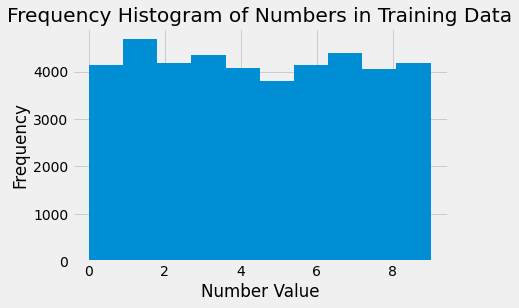

In [286]:
import matplotlib.pyplot as plt
plt.hist(trainnn["label"])
plt.title("Frequency Histogram of Numbers in Training Data")
plt.xlabel("Number Value")
plt.ylabel("Frequency")

In [287]:
label_trainnn=trainnn['label']
trainnn=trainnn.drop('label', axis=1)

trainnn = trainnn / 255
test = testtt / 255
trainnn['label'] = label_trainnn

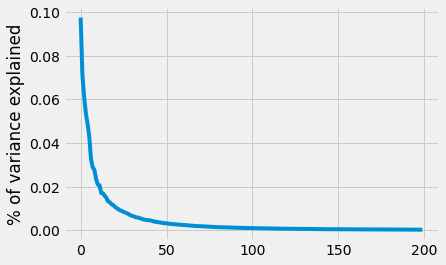

In [288]:
from sklearn import decomposition
from sklearn import datasets

pca = decomposition.PCA(n_components=200)
pca.fit(trainnn.drop('label', axis=1))
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('% of variance explained')

pca = decomposition.PCA(n_components=50)
pca.fit(trainnn.drop('label', axis=1))
PCtrainnn = pd.DataFrame(pca.transform(trainnn.drop('label', axis=1)))
PCtrainnn['label'] = trainnn['label']


PCtest = pd.DataFrame(pca.transform(test))

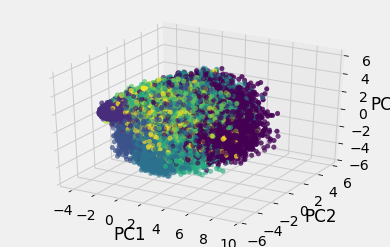

In [289]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =PCtrainnn[0]
y =PCtrainnn[1]
z =PCtrainnn[2]

colors = [int(i % 9) for i in PCtrainnn['label']]
ax.scatter(x, y, z, c=colors, marker='o', label=colors)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

In [291]:
from sklearn.neural_network import MLPClassifier
y = PCtrainnn['label'][0:20000]
X=PCtrainnn.drop('label', axis=1)[0:20000]
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(3500,), random_state=1)
clf.fit(X, y)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(3500,), random_state=1,
              solver='lbfgs')

In [292]:
from sklearn import  metrics
predicted = clf.predict(PCtrainnn.drop('label', axis=1)[20001:42000])
expected = PCtrainnn['label'][20001:42000]

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier MLPClassifier(alpha=1e-05, hidden_layer_sizes=(3500,), random_state=1,
              solver='lbfgs'):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2200
           1       0.99      0.99      0.99      2418
           2       0.97      0.97      0.97      2167
           3       0.96      0.95      0.96      2270
           4       0.97      0.98      0.98      2101
           5       0.97      0.97      0.97      2001
           6       0.98      0.98      0.98      2155
           7       0.97      0.98      0.97      2331
           8       0.97      0.96      0.96      2148
           9       0.96      0.95      0.96      2208

    accuracy                           0.97     21999
   macro avg       0.97      0.97      0.97     21999
weighted avg       0.97      0.97      0.97     21999


Confusion matrix:
[[2169    0    4    0    3    5   11    1    2    5]
 [   0 2391    5    4    1    